In [6]:
import os
import shutil
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from pickle import dump, load

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt


In [7]:
# Directories
image_folder = 'Images'
captions_file = 'captions.txt'
selected_image_folder = 'SelectedImages'
selected_captions_file = 'SelectedCaptions.txt'

In [8]:
# Create directory for selected images
if not os.path.exists(selected_image_folder):
    os.makedirs(selected_image_folder)


In [9]:
# Load captions
with open(captions_file, 'r') as file:
    captions = file.read().split('\n')


In [10]:
# Process first 1000 images
image_files = sorted(os.listdir(image_folder))[:1000]
image_ids = set([name.split('.')[0] for name in image_files])
selected_captions = []

for caption in captions:
    if caption:
        image_id = caption.split()[0].split('.')[0]
        if image_id in image_ids:
            selected_captions.append(caption)
            # Copy the image to the selected image folder
            shutil.copy(os.path.join(image_folder, image_id + '.jpg'), selected_image_folder)

In [11]:
# Save the selected captions
with open(selected_captions_file, 'w') as file:
    file.write('\n'.join(selected_captions))

In [12]:
#preprocess Captions

def load_descriptions(file_path):
    with open(file_path, 'r') as file:
        doc = file.read()
    descriptions = dict()
    for line in doc.split('\n'):
        if len(line) < 2:
            continue
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)
    return descriptions

def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = ' '.join(desc)

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    with open(filename, 'w') as file:
        file.write(data)

descriptions = load_descriptions(selected_captions_file)
clean_descriptions(descriptions)
save_descriptions(descriptions, 'descriptions.txt')


In [13]:
#spliting the data into train, test and validation

import random

def train_test_val_split(image_ids, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1):
    random.shuffle(image_ids)
    train_size = int(len(image_ids) * train_ratio)
    test_size = int(len(image_ids) * test_ratio)
    train_ids = image_ids[:train_size]
    test_ids = image_ids[train_size:train_size + test_size]
    val_ids = image_ids[train_size + test_size:]
    return train_ids, test_ids, val_ids

# Load the descriptions
descriptions = load_descriptions('descriptions.txt')
image_ids = list(descriptions.keys())

# Split the image IDs
train_ids, test_ids, val_ids = train_test_val_split(image_ids)

# Save the split IDs
with open('train_ids.txt', 'w') as file:
    file.write('\n'.join(train_ids))
with open('test_ids.txt', 'w') as file:
    file.write('\n'.join(test_ids))
with open('val_ids.txt', 'w') as file:
    file.write('\n'.join(val_ids))


In [14]:
def save_set_descriptions(descriptions, image_ids, filename):
    lines = []
    for image_id in image_ids:
        for desc in descriptions[image_id]:
            lines.append(image_id + ' ' + desc)
    data = '\n'.join(lines)
    with open(filename, 'w') as file:
        file.write(data)

save_set_descriptions(descriptions, train_ids, 'train.txt')
save_set_descriptions(descriptions, test_ids, 'test.txt')
save_set_descriptions(descriptions, val_ids, 'val.txt')


In [17]:
#Extracting Features from Images using InceptionV3


def extract_features(directory):
    model = InceptionV3(weights='imagenet')
    model = Model(model.input, model.layers[-2].output)
    features = dict()
    for name in tqdm(os.listdir(directory)):
        filename = os.path.join(directory, name)
        image = load_img(filename, target_size=(299, 299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
    return features

features = extract_features(selected_image_folder)
dump(features, open('features.pkl', 'wb'))


  0%|                                                                                         | 0/1001 [00:00<?, ?it/s]


PermissionError: [Errno 13] Permission denied: 'SelectedImages\\.ipynb_checkpoints'

In [18]:
#loading the image features in features.pkl

features = load(open('features.pkl', 'rb'))

def save_set_features(features, image_ids, filename):
    set_features = {image_id: features[image_id] for image_id in image_ids}
    dump(set_features, open(filename, 'wb'))

save_set_features(features, train_ids, 'train_features.pkl')
save_set_features(features, test_ids, 'test_features.pkl')
save_set_features(features, val_ids, 'val_features.pkl')


In [19]:
#Tokenize the Descriptions

def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

def load_descriptions(filename):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id not in descriptions:
            descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        descriptions[image_id].append(desc)
    return descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)


#saving tokenized data into tokenizer,pkl 
descriptions = load_descriptions('descriptions.txt')
tokenizer = create_tokenizer(descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
max_length = max_length(descriptions)


In [20]:
#Creating Data sequences
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

features = load(open('features.pkl', 'rb'))
X1, X2, y = create_sequences(tokenizer, max_length, descriptions, features, vocab_size)


In [21]:
#define model

#cnn
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
     #lstm
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    #combining both
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = define_model(vocab_size, max_length)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 31)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_6 (InputLayer)    │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 31, 256)           │         830,720 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 2048)              │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 31, 256)           │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_4 (NotEqual)        │ (None, 31)                │               0 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │         524,544 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 256)               │         525,312 │ dropout_1[0][0],           │
│                               │                           │                 │ not_equal_4[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dense[0][0], lstm[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │          65,792 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 3245)              │         833,965 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,780,333 (10.61 MB)

 Trainable params: 2,780,333 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
import tensorflow as tf
#creating data generator
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size, batch_size):
    while True:
        keys = list(descriptions.keys())
        for i in range(0, len(keys), batch_size):
            X1, X2, y = list(), list(), list()
            for j in range(i, min(len(keys), i + batch_size)):
                key = keys[j]
                desc_list = descriptions[key]
                photo = photos[key][0]
                for desc in desc_list:
                    seq = tokenizer.texts_to_sequences([desc])[0]
                    for k in range(1, len(seq)):
                        in_seq, out_seq = seq[:k], seq[k]
                        in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
                        out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
                        X1.append(photo)
                        X2.append(in_seq)
                        y.append(out_seq)
            yield ([np.array(X1), np.array(X2)], np.array(y))

#for undestanding purpose for tensorflow
def data_generator_tf(descriptions, photos, tokenizer, max_length, vocab_size):
    def generator():
        for key, desc_list in descriptions.items():
            photo = photos[key][0]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)
                    yield (photo, in_seq), out_seq[0]

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            (tf.TensorSpec(shape=(2048,), dtype=tf.float32),
             tf.TensorSpec(shape=(max_length,), dtype=tf.int32)),
            tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size)
    return dataset


In [23]:
# Load tokenizer, descriptions, and features
tokenizer = load(open('tokenizer.pkl', 'rb'))
vocab_size = len(tokenizer.word_index) + 1
max_length = 32  # Use the previously determined max_length

train_descriptions = load_descriptions('train.txt')
test_descriptions = load_descriptions('test.txt')
val_descriptions = load_descriptions('val.txt')

train_features = load(open('train_features.pkl', 'rb'))
test_features = load(open('test_features.pkl', 'rb'))
val_features = load(open('val_features.pkl', 'rb'))

# Create datasets
batch_size = 32
train_dataset = data_generator_tf(train_descriptions, train_features, tokenizer, max_length, vocab_size)
val_dataset = data_generator_tf(val_descriptions, val_features, tokenizer, max_length, vocab_size)

# Define and train the model
model = define_model(vocab_size, max_length)

epochs = 20
steps = len(train_descriptions) // batch_size
val_steps = len(val_descriptions) // batch_size

for i in range(epochs):
    train_dataset = data_generator_tf(train_descriptions, train_features, tokenizer, max_length, vocab_size)
    val_dataset = data_generator_tf(val_descriptions, val_features, tokenizer, max_length, vocab_size)
    model.fit(train_dataset, epochs=1, steps_per_epoch=steps, validation_data=val_dataset, validation_steps=val_steps, verbose=1)
    model.save(f'./models/model_{i}.keras')


21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 485ms/step - loss: 7.3467 - val_loss: 6.6587
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 4.8472 - val_loss: 7.0965
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 4.4539 - val_loss: 7.8199
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 4.0979 - val_loss: 7.0690
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 3.7032 - val_loss: 7.2669
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 3.4253 - val_loss: 7.7611
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 3.3654 - val_loss: 7.5824
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 3.3331 - val_loss: 7.4125
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 3.3950 - val_loss: 6.3875
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 3.2111 - val_loss: 6.9347
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 3.0469 - val_loss: 6.8892
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 2.8431 - val_loss: 6.8136
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 2.7980 - val_loss: 6.8258
21/21 ━━━━━━━━━━━━━━━━━━

Generated Caption: startseq black black dog is in in in in field endseq


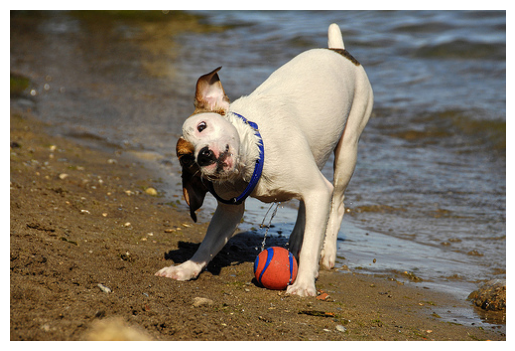

In [24]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from pickle import load
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Function to load and preprocess an image
def load_image(image_path, target_size=(299, 299)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to extract features from an image using InceptionV3
def extract_features(image_path, model):
    img = load_image(image_path)
    features = model.predict(img, verbose=0)
    return features

# Function to generate a caption for an image
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = np.pad(sequence, (0, max_length - len(sequence)), 'constant')
        yhat = model.predict([photo, np.array([sequence])], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# Helper function to map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Path to the saved model and tokenizer
model_path = './models/model_19.keras'
tokenizer_path = 'tokenizer.pkl'

# Load the captioning model
model = load_model(model_path)

# Load the tokenizer
tokenizer = load(open(tokenizer_path, 'rb'))

# Max length of sequence (used during training)
max_length = 32

# Load the pre-trained InceptionV3 model for feature extraction
inception_model = InceptionV3(weights='imagenet')
inception_model = Model(inception_model.input, inception_model.layers[-2].output)

# Path to your image
image_path = 'SelectedImages/1012212859_01547e3f17.jpg'  #  actual image path 

# Extract features from the image
photo = extract_features(image_path, inception_model)

# Generate and print the caption
caption = generate_caption(model, tokenizer, photo, max_length)
print("Generated Caption:", caption)

# Display the image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()
